# A filtered Boris algorithm for charged-particle dynamics in a strong magnetic field


Authors: Ernst Hairer, Christian Lubich, Bin Wang

Implemented by: Carla Lopez


In [1]:
import Pkg
Pkg.activate("Boris")

  Activating project at `~/Documents/Courses/Fall2024/Seminar/BorisPusher/Boris`


In [2]:
# Pkg.add("Plots") # to add packages to local env

In [3]:
using Plots
using LinearAlgebra

## Functions


In [4]:
function U(x)
    # potential energy, scalar
    return 1 / sqrt(x[1] .^ 2 + x[2] .^ 2)
end

U (generic function with 1 method)

In [5]:
function B(x, epsilon)
    # magnetic field
    return [-x[1], 0, x[3] + 1.0 / epsilon]
end

B (generic function with 1 method)

In [6]:
function E(x)
    # electric field: minus gradient of potential
    return [x[1], x[2], 0] / (x[1] .^ 2 + x[2] .^ 2)^(3 / 2)
end

E (generic function with 1 method)

Compare the numerical errors of the following methods:

– the standard Boris algorithm,

– Exp-A: the filtered Boris method of Algorithm 2.1 with $\theta$ = 1 in (2.4)
(where $\bar{x}^n = x^n$ and the method is explicit),

– Imp-A: the filtered Boris method of Algorithm 2.1 with $\theta$ of (2.5),

– Two P-A: the two-point filtered Boris method of Algorithm 7.1.


## Standard Boris integrator


In [7]:
function boris(x_0, v_0, t, nt, epsilon)
    # standard Boris integrator
    v = v_0
    x = x_0

    # Arrays to store the fields
    x_t = Array{Float64}(undef, 3, nt)
    v_t = Array{Float64}(undef, 3, nt)

    (t0, tf) = t
    h = (tf - t0) / (nt - 1)

    # Initial half-step for velocity
    v = v - (cross(v, B(x, epsilon)) + E(x))*h/2
    # Boris integrator
    for i in 1:nt
        # Store the fields
        x_t[:, i] = x
        v_t[:, i] = v

        # Half step of velocity due to electric field
        v_minus = v .+ h / 2 * E(x)

        # Magnetic field rotation
        t = h / 2 * B(x, epsilon)
        v_prime = v_minus .+ cross(v_minus, t)
        s = 2 / (1 + dot(t, t))
        v_plus = v_minus .+ s * cross(v_prime, t)

        # Half step of the velocity again
        v = v_plus .+ h / 2 * E(x)

        # Full step of the position
        x = x .+ h * v

    end
    return x_t, v_t
end

boris (generic function with 1 method)

## Exp-A

The filtered Boris method of Algorithm 2.1 with $\theta = 1$ in (2.4)
(where $\bar{x}_n = x_n$ and the method is explicit)


In [8]:
function tanc(zeta)
    return (zeta/2) > 1e-16 ? tanh(zeta / 2) / (zeta / 2) : 1.0
    
end

tanc (generic function with 1 method)

In [9]:
function Psi(h, B)
    # magnitude of matrix B
    b = norm(B)
    return I(3) + (1 - tanc(h*b/2))/b^2 * B^2
end

Psi (generic function with 1 method)

In [10]:
function exp_min(h, B)
    b = norm(B)
    return I(3) - sin(h*b)/b * B + (1 - cos(h*b))/b^2 * B^2
end

exp_min (generic function with 1 method)

In [11]:
function B_hat(b)
    # 3x3 Matrix
    return [0 -b[3] b[2]; b[3] 0 -b[1]; -b[2] b[1] 0]
end

B_hat (generic function with 1 method)

In [12]:
function boris_expA(x_0, v_0, t::Tuple, nt::Int, epsilon)
    # standard Boris integrator

    # Parameters
    (t0, tf) = t
    h = (tf - t0) / (nt - 1)

    # Arrays to store the state
    x_t = Array{Float64}(undef, 3, nt)
    v_t = Array{Float64}(undef, 3, nt)

    v = v_0
    x = x_0

    # Initial half-step for velocity
    v = v - (cross(v, B(x, epsilon)) + E(x))*h/2
    for i in 1:nt
        # Store the position and velocity
        x_t[:, i] = x
        v_t[:, i] = v

        b_hat = B_hat(B(x, epsilon))
        v_plus = v + h / 2 * Psi(h,  b_hat) * E(x)

        v_minus = exp(-h*b_hat) * v_plus

        v = v_minus + h / 2 * Psi(h,  b_hat) * E(x)

        # Full step of the position
        x = x + h * v

    end
    return x_t, v_t
end

boris_expA (generic function with 1 method)

## Imp-A

The filtered Boris method of Algorithm 2.1 with $\theta$ of (2.5)


In [13]:
function x_center(x, v, B)
    # Center of the cyclotron motion
    return x + cross(v, B) / norm(B)^2
end

x_center (generic function with 1 method)

In [14]:
function x_bar(theta, x, v, B)
    # Center of the cyclotron motion
    return theta*x + (1 - theta)*x_center(x, v, B)
end

x_bar (generic function with 1 method)

In [15]:
function theta(h, B)
    return 1 / sinc(h*norm(B) / 2)^2
end

theta (generic function with 1 method)

In [31]:
function boris_impA(x_0, v_0, t::Tuple, nt::Int, epsilon)
    # standard Boris integrator

    # Parameters
    (t0, tf) = t
    h = (tf - t0) / (nt - 1)

    # Arrays to store the state
    x_t = Array{Float64}(undef, 3, nt)
    v_t = Array{Float64}(undef, 3, nt)

    v = v_0
    x = x_0

    # Initial half-step for velocity
    v = v - (cross(v, B(x, epsilon)) + E(x))*h/2
    for i in 1:nt
        # Store the position and velocity
        x_t[:, i] = x # x^{n}
        v_t[:, i] = v # v^{n-1/2}

        B_n = B(x, epsilon)
        B_hat_n = B_hat(B_n)

        # v^{n-1/2}_{+}
        v_plus = v + h / 2 * Psi(h,  B_hat_n) * E(x)

        theta_n = theta(h, B_n)
        
        x_bar_n = x
        tol = 1
        v_minus = 0
        while tol > 1e-6
            b_bar_n = B(x_bar_n, epsilon)
            # v^{n-1/2}_{-} = exp(-h*B_hat_bar_n)) * v^{n-1/2}_{+}
            v_minus = exp(-h*B_hat(b_bar_n)) * v_plus

            # n^n
            vn = Phi_1(h, B_hat(b_bar_n)) * 1/2 * (v_minus + v_plus) - h * Gamma(h, B_hat_n) * E(x)

            x_bar_n_ = x_bar(theta_n, x, vn, B_n)

            tol = norm(x_bar_n - x_bar_n_) / norm(x_bar_n_)
            x_bar_n = x_bar_n_
        end

        # v^{n+1/2}
        v = v_minus + h / 2 * Psi(h,  B_hat_n) * E(x)

        # Full step of the position x^{n+1}
        x = x + h * v

    end
    return x_t, v_t
end

boris_impA (generic function with 1 method)

In [17]:
function Phi_1(h, X)
    x = norm(X)
    return I + (1-tanc(h*x/2))/x^2 * X^2
end

Phi_1 (generic function with 1 method)

In [18]:
function Gamma(h, X)
    x = norm(X)
    return I - (1 - 1/sinc(h*x))/(h*x^2)*X^2
end

Gamma (generic function with 1 method)

# Simulations


In [19]:
# let's start with one particle of unit mass and charge
x_0 = [1 / 3, 1 / 4, 1 / 2];

# and initial velocity
v_0 = [2 / 5, 2 / 3, 1];

In [20]:
# numerical parameters
t0 = 0;
tf = 1;

j = 7
epsilon = (1 / 2)^j;

h = epsilon;
nt = Int((tf - t0) / h + 1)
# nt = 4000;

println("epsilon = ", epsilon)
println("h = ", h)
println("nt = ", nt)


epsilon = 0.0078125
h = 0.0078125
nt = 129


In [21]:
# Standard Boris
x_tB, v_tB = boris(x_0, v_0, (t0, tf), nt, epsilon)

([0.3333333333333333 0.3392132975260416 … 0.3539555827449509 0.3554049582991948; 0.25 0.25373502604166664 … 0.20740011698887842 0.21397023379416824; 0.5 0.5078192816840278 … 1.4834126962488134 1.4910956398112398], [0.04736458333333338 0.7526354166666666 … -0.5910184295825155 0.18552007094320905; 0.85525 0.4780833333333333 … 0.615124757000984 0.8409749510770982; 0.9991319444444444 1.0008680555555556 … 0.9814035157534295 0.9834167759905683])

In [22]:
# expA Boris
x_tE, v_tE = boris_expA(x_0, v_0, (t0, tf), nt, epsilon)

([0.3333333333333333 0.33945814481419284 … 0.3655146095188635 0.36382298932648144; 0.25 0.2533014728370462 … 0.21519293017403968 0.20820725475959614; 0.5 0.5078199168261501 … 1.4834872383535986 1.491162368131213], [0.04736458333333338 0.783975869550018 … 0.6228821500390429 -0.21652738462490365; 0.85525 0.4225885231419144 … -0.6876149841274266 -0.8941664530487715; 0.9991319444444444 1.0009493537472114 … 0.9848917872280465 0.9824166115346441])

In [32]:
# impA Boris
x_tI, v_tI = boris_impA(x_0, v_0, (t0, tf), nt, epsilon)

([0.3333333333333333 0.33945518927512736 … 0.3648017588933423 0.36309498190193257; 0.25 0.25329605792110926 … 0.21514279549066556 0.20814187821020308; 0.5 0.5078243904347758 … 1.480661679202928 1.48829082237602], [0.04736458333333338 0.7835975605496385 … 0.6231054144918 -0.2184674549004511; 0.85525 0.42189541390198504 … -0.6897770289135207 -0.8961174118991965; 0.9991319444444444 1.0015219756513065 … 0.9797051647203825 0.9765303261557985])

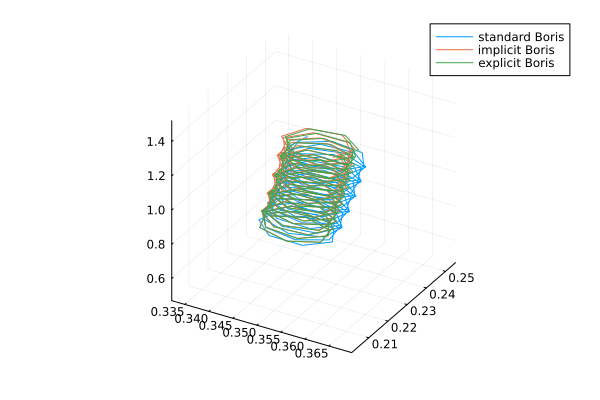

In [33]:
# plot the trajectory
plot(x_tB[1, :], x_tB[2, :], x_tB[3, :], label="standard Boris")
plot!(x_tI[1, :], x_tI[2, :], x_tI[3, :], label="implicit Boris")
plot!(x_tE[1, :], x_tE[2, :], x_tE[3, :], label="explicit Boris")

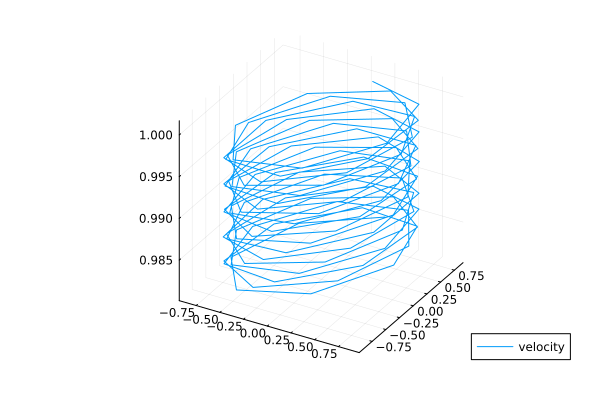

In [34]:
# plot the velocity
plot(v_tB[1, :], v_tB[2, :], v_tB[3, :], label="velocity")